In [38]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

from google.colab import files
uploaded = files.upload()

Saving viettri_quality.csv to viettri_quality.csv


In [39]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('viettri_quality.csv')
df1=df.reset_index()['pm25']

In [40]:
df1.shape

(1920,)

In [41]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [42]:
df1.shape

(1920, 1)

In [43]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [44]:
print(train_size)
print(test_size)

1344
576


In [45]:
print(train_data.shape)
print(test_data.shape)


(1344, 1)
(576, 1)


In [46]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [47]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [48]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)

(1243, 100)
(1243,)
(475, 100)
(475,)


In [49]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print(X_train.shape)
print(X_test.shape)

(1243, 100, 1)
(475, 100, 1)


In [50]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [51]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 11s 293ms/step - loss: 0.0339 - val_loss: 0.0192
Epoch 2/100
20/20 [==============================] - 4s 209ms/step - loss: 0.0249 - val_loss: 0.0190
Epoch 3/100
20/20 [==============================] - 4s 187ms/step - loss: 0.0246 - val_loss: 0.0181
Epoch 4/100
20/20 [==============================] - 4s 199ms/step - loss: 0.0244 - val_loss: 0.0186
Epoch 5/100
20/20 [==============================] - 5s 264ms/step - loss: 0.0243 - val_loss: 0.0181
Epoch 6/100
20/20 [==============================] - 4s 187ms/step - loss: 0.0239 - val_loss: 0.0178
Epoch 7/100
20/20 [==============================] - 4s 186ms/step - loss: 0.0237 - val_loss: 0.0182
Epoch 8/100
20/20 [==============================] - 5s 274ms/step - loss: 0.0238 - val_loss: 0.0182
Epoch 9/100
20/20 [==============================] - 4s 185ms/step - loss: 0.0237 - val_loss: 0.0195
Epoch 10/100
20/20 [==============================] - 4s 188ms/step - loss: 0.0237 - val_l

In [52]:
X_test.shape

(475, 100, 1)

In [53]:
# 10. Dự báo dữ liệu test,
train_predict=model.predict(X_train)
y_pred=model.predict(test_data.reshape(test_data.shape[0],test_data.shape[1] , 1))


18/18 [==============================] - 2s 4ms/step


In [54]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

print(test_data.shape)
print(y_pred.shape)

(576, 1)
(576, 1)


In [55]:
ytest=scaler.inverse_transform(test_data)
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(ytest - y_pred)/np.abs(ytest))*100

print('Testing MAPE:', test_mape)

# Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 33.34780915070041
Testing MAPE: 73.31971041717232
Testing MAE: 26.69111076162921


In [57]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape

(1, 516)

In [58]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=516
i=0
while(i<90):

    if(len(temp_input)>516):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
 0.18644068 0.38983051 0.3220339  0.28248588 0.21468927 0.16949153
 0.07344633 0.11864407 0.33898305 0.15819209 0.1299435  0.2259887
 0.25988701 0.3559322  0.48587571 0.55932203 0.46892655 0.52542373
 0.50282486 0.4180791  0.48022599 0.57062147 0.65536723 0.63276836
 0.1920904  0.27683616 0.37853107 0.1920904  0.2259887  0.20903955
 0.20903955 0.49152542 0.49152542 0.56497175 0.56497175 0.46892655
 0.38418079 0.4180791  0.3559322  0.3220339  0.18079096 0.21468927
 0.15254237 0.10734463 0.24293785 0.29378531 0.3220339  0.36723164
 0.36158192 0.50847458 0.51412429 0.44632768 0.51977401 0.49717514
 0.36723164 0.4180791  0.4519774  0.25423729 0.35028249 0.31073446
 0.30508475 0.38983051 0.36723164 0.33333333 0.20338983 0.0960452
 0.05084746 0.0960452  0.20338983 0.3220339  0.25988701 0.19774011
 0.6440678  0.00564972 0.00564972 0.37853107 0.44632768 0.
 0.29378531 0.29943503 0.32768362 0.35028249 0.24858757 0.28248588
 0.38418079 0.2

In [59]:
print(x_input.shape)
print(test_data.shape)
print(y_pred.shape)

(1, 516, 1)
(576, 1)
(576, 1)


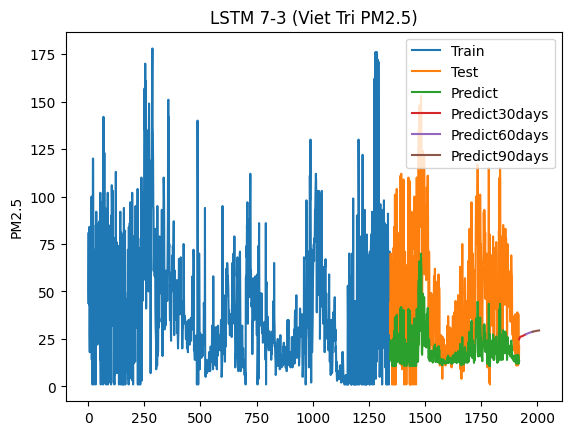

In [60]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.title('LSTM 7-3 (Viet Tri PM2.5)')
plt.ylabel('PM2.5')
plt.show()

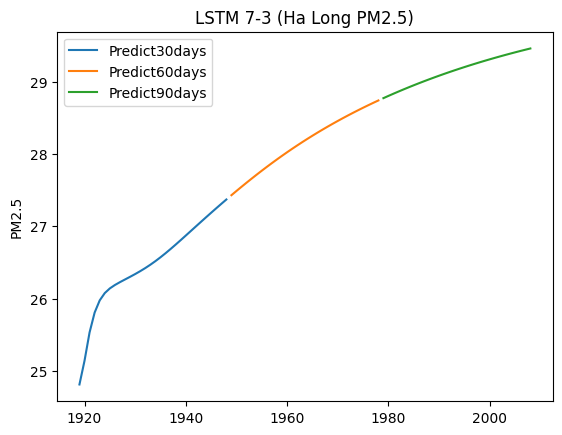

In [61]:
# 14.Vẽ hình
# Dự đoán 90 ngày tiếp theo

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.title('LSTM 7-3 (Ha Long PM2.5)')
plt.ylabel('PM2.5')
plt.show()

In [ ]:
print(scaler.inverse_transform(lst_output))

[[40.98455468]
 [41.61088896]
 [42.24906108]
 [42.66434842]
 [42.92320818]
 [43.05660754]
 [43.09695932]
 [43.07200521]
 [43.00471693]
 [42.91355285]
 [42.81299949]
 [42.71414128]
 [42.62494782]
 [42.55069056]
 [42.49413592]
 [42.45585364]
 [42.43461946]
 [42.42793065]
 [42.4324958 ]
 [42.44480923]
 [42.46153712]
 [42.4798401 ]
 [42.49752152]
 [42.51310283]
 [42.5257906 ]
 [42.53531173]
 [42.54186398]
 [42.54591587]
 [42.5481078 ]
 [42.54912961]
 [42.54963344]
 [42.55018672]
 [42.55121323]
 [42.55300727]
 [42.55570069]
 [42.55933115]
 [42.56382096]
 [42.56904769]
 [42.57484654]
 [42.58101973]
 [42.58740482]
 [42.59385583]
 [42.60025033]
 [42.60652712]
 [42.61261791]
 [42.61852035]
 [42.62423915]
 [42.62978843]
 [42.63521057]
 [42.64053854]
 [42.64581707]
 [42.65106735]
 [42.65631291]
 [42.66157025]
 [42.66685584]
 [42.67216969]
 [42.67750943]
 [42.68286094]
 [42.688236  ]
 [42.6936087 ]
 [42.69898376]
 [42.70434234]
 [42.70968443]
 [42.71500769]
 [42.72030976]
 [42.72558358]
 [42.73083